In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


In [2]:
import wget
training=wget.download('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv',bar=None)

In [6]:
corpus=[]
num_sentences=0

with open(training,encoding='utf8') as csvfile:
    reader=csv.reader(csvfile,delimiter=',')
    
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences=num_sentences+1
        corpus.append(list_item)

In [9]:
print(num_sentences)
print(len(corpus))
print(corpus[1])
print(corpus[0])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]
["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", 0]


In [8]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

In [10]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [11]:
print(vocab_size)
print(word_index['i'])

138854
1


In [13]:
glove=wget.download('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt',bar=None)

In [17]:
embeddings_index={}
with open(glove,encoding='utf8') as f:
    for line in f:
        values= line.split()
        word=values[0]
        coefs=np.asarray(values[1:],dtype='float32')
        embeddings_index[word]=coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [18]:
print(len(embeddings_matrix))

138855


In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13885500  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)        

In [22]:
history = model.fit(training_sequences, training_labels, epochs=50, validation_data=(test_sequences, test_labels), verbose=2)


Train on 144000 samples, validate on 16000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 105s - loss: 0.5671 - acc: 0.6986 - val_loss: 0.5214 - val_acc: 0.7389
Epoch 2/50
 - 95s - loss: 0.5256 - acc: 0.7336 - val_loss: 0.5067 - val_acc: 0.7471
Epoch 3/50
 - 85s - loss: 0.5101 - acc: 0.7458 - val_loss: 0.5084 - val_acc: 0.7474
Epoch 4/50
 - 96s - loss: 0.4978 - acc: 0.7549 - val_loss: 0.5011 - val_acc: 0.7531
Epoch 5/50
 - 95s - loss: 0.4901 - acc: 0.7584 - val_loss: 0.4972 - val_acc: 0.7551
Epoch 6/50
 - 97s - loss: 0.4828 - acc: 0.7646 - val_loss: 0.5062 - val_acc: 0.7484
Epoch 7/50
 - 97s - loss: 0.4765 - acc: 0.7688 - val_loss: 0.4986 - val_acc: 0.7526
Epoch 8/50
 - 95s - loss: 0.4707 - acc: 0.7715 - val_loss: 0.4963 - val_acc: 0.7537
Epoch 9/50
 - 95s - loss: 0.4680 - acc: 0.7738 - val_loss: 0.4973 - val_acc: 0.7556
Epoch 10/50
 - 95s - loss: 0.4636 - acc: 0.7755 - val_loss: 0.5051 - val_acc: 0.7536
Epoch 11/50
 - 96s - loss: 0.4611 - acc: 0.7782 - val_loss:

<Figure size 432x288 with 0 Axes>

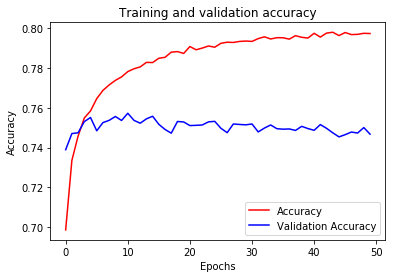

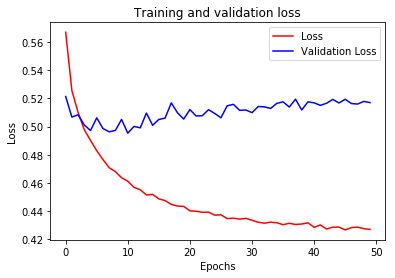

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!